In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from functions.conv1fxn import *
from functions.functions_image_training import *
import numpy as np
import tensorflow as tf
import pickle
import h5py
import os.path
import sys
import timeit
%matplotlib inline

In [9]:
with h5py.File('data/qualdata3.h5', 'a') as qd:
    training_labels = np.array(qd.get('training_labels')).astype('uint8')
    training_tensors = np.array(qd.get('training_tensors')).astype('uint8')

In [10]:
num_examples, num_classes = training_labels.shape
batch_size = 30
num_steps = int(num_examples/ batch_size)
_,target_height,target_width,target_depth = training_tensors.shape
epochs = 2
portion_for_validation = 0.2 

In [11]:
################ TENSOR FLOW #########################################
### TF variables #####################################################
tensor_image = tf.placeholder("uint8", [None, None, 3])

############ Manipulations to tensors in TF variables ########################
#### Resizing tesors #################################################################
resized_image = tf.image.resize_images(tensor_image, target_height, target_width)

######## Manipulations to resized tensors in Resizing tensors ####################
lrflip_resized = tf.image.flip_left_right(resized_image)
udflip_resized = tf.image.flip_up_down(resized_image)

####### BUILD NEURAL NET ARCHITECTURE ########################################
x = tf.placeholder(tf.float32, shape=[None, target_height,target_width,target_depth])
y_ = tf.placeholder(tf.float32, shape=[None, num_classes])

W_conv1 = weight_variable([10, 10, 3, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
print('h_conv1 shape', h_conv1.get_shape().as_list())
h_pool1 = max_pool_2x2(h_conv1)
print('h_pool1 shape', h_pool1.get_shape().as_list())

W_conv2 = weight_variable([5, 5, 32, 30])
b_conv2 = bias_variable([30])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
print('h_conv2 shape', h_conv2.get_shape().as_list())

W_conv3 = weight_variable([5, 5, 30, 28])
b_conv3 = bias_variable([28])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3) + b_conv3)

h_conv3_shape =  h_conv3.get_shape().as_list()
print('h_conv3_shape', h_conv3_shape)

W_fc1 = weight_variable([h_conv3_shape[1] * h_conv3_shape[2] * h_conv3_shape[3], 100])
b_fc1 = bias_variable([100])

# reshape x to 4d tensor[-1,width,height,depth, channels]
h_conv3_flat = tf.reshape(h_conv3, [-1, h_conv3_shape[1] * h_conv3_shape[2] * h_conv3_shape[3]])
print('h_conv3_flat shape', h_conv3_flat.get_shape().as_list())
h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

# probability that a neuron's output is kept during dropout
keep_prob = tf.placeholder(tf.float32)

#dropout layer
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
print('h_fc1_drop shape', h_fc1_drop.get_shape().as_list())

W_fc2 = weight_variable([100, 64])
b_fc2 = bias_variable([64])

h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
print('h_fc2  shape', h_fc2 .get_shape().as_list())

W_fc3 = weight_variable([64, num_classes])
b_fc3 = bias_variable([num_classes])

#################### SOFTMAX layer ###############################
h_fc3_logits = tf.matmul(h_fc2, W_fc3) + b_fc3

y_soft=tf.nn.softmax(h_fc3_logits)
print('y_soft shape', y_soft.get_shape().as_list())

###################### REGULARIZATION ##############################
L2_reg_const = 1e-6

L2_reg = (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(W_conv3)
+ tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc3))

#DEFINE COST FXN as cross entropy loss
cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y_soft,1e-10,1.0)))  + L2_reg_const*L2_reg

#DEFINE OPTIMIZER Instance
#train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-5
learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.95,staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
#evaluate accuracy as boolean
correct_prediction = tf.equal(tf.argmax(y_soft,1), tf.argmax(y_,1))
#evaluate accuracy as binary average
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


######## initialization class for session running ############################
model = tf.initialize_all_variables()
print('session initialized variables')

h_conv1 shape [None, 221, 221, 32]
h_pool1 shape [None, 110, 110, 32]
h_conv2 shape [None, 53, 53, 30]
h_conv3_shape [None, 25, 25, 28]
h_conv3_flat shape [None, 17500]
h_fc1_drop shape [None, 100]
h_fc2  shape [None, 64]
y_soft shape [None, 3]
session initialized variables


In [ ]:
start_time = timeit.default_timer()

example_index = list(range(num_examples))
random.shuffle(example_index)

shuffled_all_images = training_tensors[example_index]/255
shuffled_all_labels = training_labels[example_index]/255 

start_of_training = int(portion_for_validation*num_examples)

test_images = shuffled_all_images[:start_of_training]
test_labels = shuffled_all_labels[:start_of_training]
training_images = shuffled_all_images[start_of_training:]
training_labels = shuffled_all_labels[start_of_training:]

training_index = list(range(num_examples - start_of_training))
########## TRAINING LOOP #####################################################
with tf.Session() as session: 
    saver = tf.train.Saver()
    saved_model = "models/QualModelsmall.ckpt"

    if os.path.isfile(saved_model):
        print('Found', saved_model)
        saver.restore(session, saved_model)
        print(saved_model, "Model restored.")
    else:
        print('No saved Model')
        best_val_acc = np.float32(1/num_classes)
        print('best_val_acc',best_val_acc)
    
    session.run(model)
    
########## NUMBER OF EPOCHS ##################################################
    for epoch in range(epochs):
        print('epoch', epoch, 'steps:', num_steps)
        random.shuffle(training_index)

        shuffled_images = training_images[training_index]
        shuffled_labels = training_labels[training_index]
        
        for step in range(num_steps):
            offset = (step * batch_size) % (num_examples)
            start = offset
            end = offset + batch_size
            if num_examples - end < batch_size:
                end += (num_examples % batch_size)
                
    ####### USE 'start' and 'end' to build one BATCH #####################################
    ####### HERE ################################################################
            batch_labels = shuffled_labels[start:end] 
            batch_images = shuffled_images[start:end]  
            
########### FEED TRAINING BATCH TO NETWORK ##########################################
########### HERE ####################################################################

            train_batch,Loss = session.run([train_step,cross_entropy],
                               feed_dict={x:batch_images, y_:batch_labels, keep_prob:1.0})
    
            print('finished step ', step, 'learning rate' ,learning_rate.eval(), 'Loss:',Loss)
            print("max W vales: %g %g %g %g %g %g"%(tf.reduce_max(tf.abs(W_conv1)).eval(),
                tf.reduce_max(tf.abs(W_conv2)).eval(),tf.reduce_max(tf.abs(W_conv3)).eval(),
                tf.reduce_max(tf.abs(W_fc1)).eval(),tf.reduce_max(tf.abs(W_fc2)).eval(),
                tf.reduce_max(tf.abs(W_fc3)).eval()))

            print("max b vales: %g %g %g %g %g %g"%(tf.reduce_max(tf.abs(b_conv1)).eval(),
                  tf.reduce_max(tf.abs(b_conv2)).eval(), tf.reduce_max(tf.abs(b_conv3)).eval(),
                  tf.reduce_max(tf.abs(b_fc1)).eval(),tf.reduce_max(tf.abs(b_fc2)).eval(),
                  tf.reduce_max(tf.abs(b_fc3)).eval())) 
            
            print("min W vales: %g %g %g %g %g %g"%(tf.reduce_min(tf.abs(W_conv1)).eval(),
                  tf.reduce_min(tf.abs(W_conv2)).eval(),tf.reduce_min(tf.abs(W_conv3)).eval(),
                  tf.reduce_min(tf.abs(W_fc1)).eval(),tf.reduce_min(tf.abs(W_fc2)).eval(),
                  tf.reduce_min(tf.abs(W_fc3)).eval()))

            valid_acc = session.run(accuracy, feed_dict={x: test_images, y_: test_labels,  keep_prob: 1.0})
            print("Validation Accuracy: %g"% valid_acc)
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                print('NEW best_val_acc')
                save_path = saver.save(session, saved_model)
                print("Model saved in file: %s" % save_path)
#######################################################################################

end_time = timeit.default_timer()
print('DONE, ran for %.2fm' % ((end_time - start_time) / 60.))

213


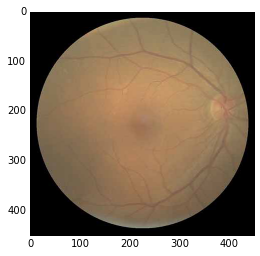

In [41]:
test = batch_images[0]
print(np.amax(test))
plt.imshow(test)
plt.show()

In [6]:
session.close()